<a href="https://colab.research.google.com/github/yesiltepe-hidir/GAN/blob/main/IAF_VAE_Model_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, SigmoidTransform, Uniform, TransformedDistribution
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

## IAF - VAE Model

In [2]:
class MaskedLinear(nn.Linear):
    """
    Special Linear Module that applies masked linear transformation to its input.
    This layer is the core layer that will be used by MADE. 

    # Mask Types:
    - For density estimation model to be autoregressive, there needs to be applied 
    some fixed masks. [Note that, this doesn't need to be fixed, connections can be generated using coltrolled randomness as well.]
    - Masks are the following types:

    First Layer Mask: 
    [For 3 x 3 case]
                              | 0  0  0 |
                              | 1  0  0 |
                              | 1  1  0 |
    Other Layer Mask:
    [For 3 x 3 case]
                              | 1  0  0 |
                              | 1  1  0 |
                              | 1  1  1 |
    """
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


In [3]:
class MADE(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, num_masks=1, natural_ordering=False):
        """
        Masked Autoencoder Density Estimator:
        https://arxiv.org/pdf/1502.03509.pdf

        This module will be primarly used for AutoregressiveNN module that will 
        autoregressively estimate go from x -> z [Inverse Flow]
        """
        
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        
        # define a simple MLP neural net
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop() # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net)
        
        # seeds for orders/connectivities of the model ensemble
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = 0 # for cycling through num_masks orderings
        
        self.m = {}
        self.update_masks() 
        
    def update_masks(self):
        if self.m and self.num_masks == 1: return # only a single seed, skip for efficiency
        L = len(self.hidden_sizes)
        
        # fetch the next seed and construct a random stream
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        
        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])
        
        # construct the mask matrices
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        # handle the case where nout = nin * k, for integer k > 1
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            # replicate the mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)
        
        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        return self.net(x)

In [4]:
class AutoregressiveNN(nn.Module):

    def __init__(self, in_features, out_features, hidden_features):
        super().__init__()
        self.net = MADE(in_features, 
                        [hidden_features, hidden_features, hidden_features], 
                        out_features, 
                        num_masks=1, 
                        natural_ordering=True)
        
    def forward(self, x):
        return self.net(x)

In [5]:
class IAF(nn.Module):
    """ Masked Autoregressive Flow that uses a MADE-style network for fast forward """
    
    def __init__(self, dim, parity, net_class=AutoregressiveNN, nh=24):
        super().__init__()
        self.dim = dim
        self.net = net_class(dim, 2*dim, nh)

        self.parity = parity

    def forward(self, z):
        # we have to decode the x one at a time, sequentially
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.size(0))
        z = z.flip(dims=(1,)) if self.parity else z
        for i in range(self.dim):
            st = self.net(x.clone()) # clone to avoid in-place op errors if using IAF
            s, t = st.split(self.dim, dim=1)
            x[:, i] = (z[:, i] - t[:, i]) * torch.exp(-s[:, i])
            log_det += -s[:, i]
        return x, log_det

In [6]:
class NormalizingFlow(nn.Module):

    def __init__(self, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m)
        zs = [x]
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
            zs.append(x)
        return zs, log_det

    def backward(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m)
        xs = [z]
        for flow in self.flows[::-1]:
            z, ld = flow.backward(z)
            log_det += ld
            xs.append(z)
        return xs, log_det

In [7]:
class NormalizingFlowModel(nn.Module):
    """ A Normalizing Flow Model is a (prior, flow) pair """
    
    def __init__(self, prior, flows):
        super().__init__()
        self.prior = prior
        self.flow = NormalizingFlow(flows)
    
    def forward(self, x):
        zs, log_det = self.flow.forward(x)
        prior_logprob = self.prior.log_prob(zs[-1]).view(x.size(0), -1).sum(1)
        return zs, prior_logprob, log_det

    def backward(self, z):
        xs, log_det = self.flow.backward(z)
        return xs, log_det
    
    def sample(self, num_samples):
        z = self.prior.sample((num_samples,))
        xs, _ = self.flow.backward(z)
        return xs

In [8]:
class MLP(nn.Module):
    """ a simple 4-layer MLP """

    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nin, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nout),
        )
    def forward(self, input):
        return self.net(input)

In [9]:
class VAE(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dim, prior, flows):
        super().__init__()
        self.dim = input_dim
        self.prior = prior
        self.encoder = NormalizingFlowModel(prior, flows)
        self.decoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(encoding_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 2*input_dim),
        )
        
    
    def forward(self, input):
        zs, prior_logprob, log_det = self.encoder(input.float())
        kl = prior_logprob + log_det

        m, s = self.decoder(zs[-1]).split(self.dim, dim=1)
        eps = torch.randn(s.size())
        x_hat = m + eps * torch.exp(s)
        recon = F.mse_loss(input, x_hat)

        loss = torch.mean(-kl + recon)
        return m, s, loss

# Experiments

# Architecture
Which architecture did you use for your implementation, why, and were the results the way you expected them? Please provide references if you used well-known models.

**Answer:** The Encoder of the `IAF-VAE` consists of Series of IAF-Layers. In the encoder, only inverse flow is used and input x is tranformed into a complex distribution in latent space. Reconstructions are normally distributed and to capture the parameters of the normal distribution that describes the dataset, model fits an `Multilayer Perceptron` in the decoder to get mean and log variance. 

In Autoregressive Neural Network, model uses `MADE` architecture in an attempt to capture next random variable in the flow in autoregressive fashion. `Masked Linear Layer` is the core building block of the `MADE` architecture.

The reason we use such an autoregressive architecture is that to get:
~~~~
Normalizing Flow Model that has easy-to-compute Jacobian
~~~~
With the help of autoregressive implementation, the Jacobian matrix becomes lowe triangular and further, the determinant becomes the sum of log of diagonal entries!

Results are actually not expected, I didn't aware that the bidirectional training of Normalizing Flow Models that hard! I tried very hard to employ a bidirectional IAF model but model was insisting not to train... I had to changed the architecture immensely.

# Autoregressive Neural Network
Explain why your autoregressive neural network implementation maintains the autoregressive property.

**Answer:** To understand this let's take a look at the inverse flow closely:
~~~~
Imagine inverse flow [x -> z] as [x -> z1 -> z2 -> ... -> zn]. In this sequential 
flow pipeline, every z_{t+1, i} component is generated using the components of type z_{t, <i}.

Further, MADE model estimates the parameters of the posterior distribution p(z |x). MADE density estimator
connects the nodes in an autoregressive fashion.
~~~~

# Inverse Autoregressive Transformations
What is the adventage of Inverse Autoregressive Transformations over the Autoregressive Transformations? You may refer to the [IAF paper](https://arxiv.org/abs/1606.04934).

**Answer:** In traditional Inverse Autoregressive Transformation has the following crucial property as opposed to other Autoregressive Transformations:
~~~~
                  Although going from x -> z [inverse flow] still autoregressive 
                  and sequential in IAF, forward flow is parallelizable, 
                  meaning that flows going z -> x, provides fast sampling. 
~~~~

## Environment
Which python version did you use? Also, if you used any extra libraries, please list them below.

- PyTorch
- Numpy
- Matplotlib


In [10]:
import sys
sys.version

'3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]'

## Plotting Heatmaps

We will be using heatmaps to examine probabilities calculated by our model. The plotting function is given below.

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


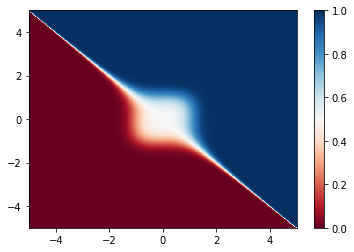

In [11]:
def plot_heatmap(x,y,probabilities):
    # interpretation of input: the point (x[i],y[i]) has the probability probabilities[i]
    
    fig, ax = plt.subplots()
    c = ax.pcolormesh(x, y, probabilities, cmap='RdBu', vmin=0, vmax=1)

    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)

    plt.show()

import matplotlib.pyplot as plt
import torch

# example usage
y, x = torch.meshgrid(torch.linspace(-5, 5, 500), torch.linspace(-5, 5, 500)) # produce x-y pairs
probabilities = torch.sigmoid(x**3+y**3)
plot_heatmap(x,y,probabilities)

# Experiments: Dataset A

## Different Learning Rates
Train your model with at least 3 different learning rates to help you pick a nice learning rate. Make sure that you do not change any other hyperparameters. The batch, encoding sizes and number of epochs you use is up to you. Resetting random number generators between runs will help you achieve more consistent results. You will use the test set loss to determine the best model.

### Results
Plot the training and validation losses together: one plot for the training losses and one for the validation losses. Plot the heatmap of variational lower-bound (ELBO) for the best model.

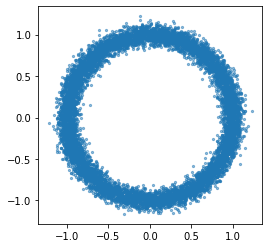

In [123]:
class PointDataset:
  def __init__(self, file_path):
    self.data = np.load(file_path)

  
  def __getitem__(self, idx):
    return self.data[idx]
  
  def __len__(self):
    return self.data.shape[0]

d = PointDataset('/content/DatasetA_train.npy') 
train_data = torch.utils.data.DataLoader(d[:-500], batch_size=256, shuffle=True)
valid_data = torch.utils.data.DataLoader(d[-500:], batch_size=256, shuffle=True)

plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.axis('equal');

## LR = 1e-3

## Config

In [124]:
# Prior
input_dim = 2
encoding_dim = 4
hidden_dim = 128
prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)

In [125]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  21796


## Training

In [126]:
num_epoch = 10
train_losses = []
valid_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in train_data:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        with torch.no_grad():
          model.eval()
          for point_batch in valid_data:
            
            m, s, loss = model(points.float())
            valid_losses.append(loss)
          
          model.train()


        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

[2/10] 1.9901068210601807
--------------------
[5/10] 1.9258301258087158
--------------------
[7/10] 1.9739106893539429
--------------------


torch.Size([256, 2])


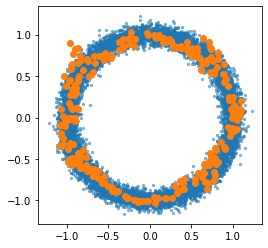

In [16]:
data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

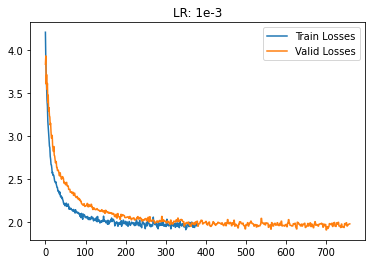

In [17]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title('LR: 1e-3')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

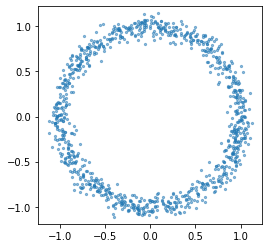

In [18]:
d = PointDataset('/content/DatasetA_test.npy')
test_data = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.axis('equal');

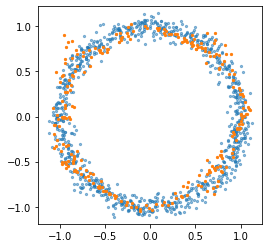

In [19]:
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), s=5)
plt.axis('equal');

# LR = 1e-4

In [20]:
# Prior
input_dim = 2
encoding_dim = 4
hidden_dim = 128
prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)

In [21]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  21796


In [22]:
num_epoch = 10
train_losses = []
valid_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in train_data:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        with torch.no_grad():
          model.eval()
          for point_batch in valid_data:
            
            m, s, loss = model(points.float())
            valid_losses.append(loss)
          
          model.train()


        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

[2/10] 3.247194766998291
--------------------
[5/10] 2.7246391773223877
--------------------
[7/10] 2.4270362854003906
--------------------


torch.Size([256, 2])


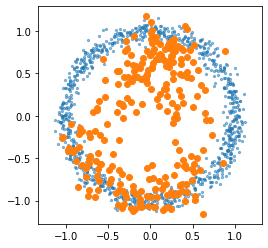

In [23]:
data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

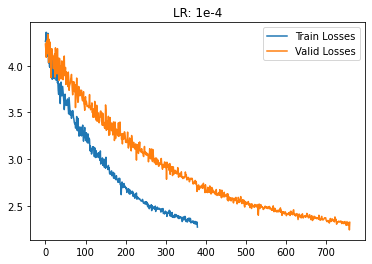

In [24]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title('LR: 1e-4')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

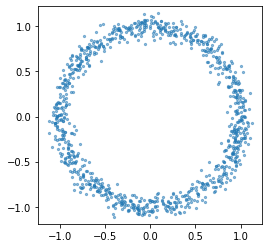

In [25]:
d = PointDataset('/content/DatasetA_test.npy')
test_data = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.axis('equal');

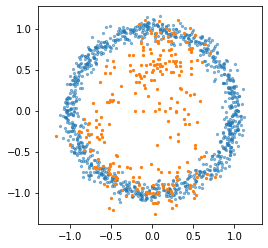

In [26]:
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), s=5)
plt.axis('equal');

## LR = 1e-5

In [27]:
# Prior
input_dim = 2
encoding_dim = 4
hidden_dim = 128
prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)


In [28]:
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  21796


In [29]:
num_epoch = 10
train_losses = []
valid_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in train_data:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        with torch.no_grad():
          model.eval()
          for point_batch in valid_data:
            
            m, s, loss = model(points.float())
            valid_losses.append(loss)
          
          model.train()


        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

[2/10] 4.326578140258789
--------------------
[5/10] 4.128098487854004
--------------------
[7/10] 3.7653205394744873
--------------------


torch.Size([256, 2])


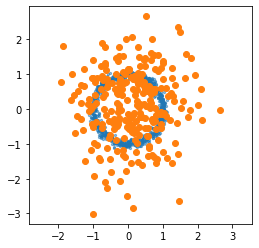

In [30]:
data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

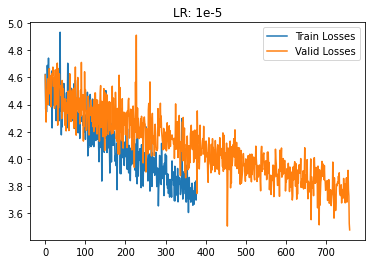

In [31]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title('LR: 1e-5')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

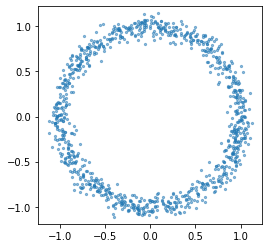

In [32]:
d = PointDataset('/content/DatasetA_test.npy')
test_data = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.axis('equal');

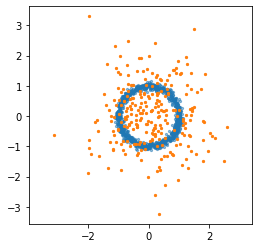

In [33]:
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), s=5)
plt.axis('equal');

## Heatmap


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


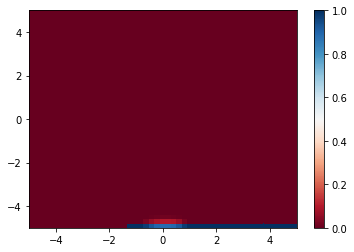

In [151]:
xs = torch.linspace(-5, 5, 50)
ys = torch.linspace(-5, 5, 50)
x, y = torch.meshgrid(xs, ys)
coords = []
for i in zip(x.reshape(-1), y.reshape(-1)):
  coords.append(i)

coords = torch.tensor(coords)
coords.reshape(-1, 2)
probabilities = []
for point in coords:
  m, s, loss = model(point.reshape(1, 2))
  probabilities.append(loss)

probabilities = torch.tensor(probabilities)
probabilities = F.softmax(probabilities.reshape(-1, 50))
plot_heatmap(x, y, probabilities)

## Different Encoding Sizes
At this point you more or less know a decent range to use for your learning rate. It's time to try out different encoding sizes, which is the size of the vector **z**! Train your model with 3 different encoding sizes of your choice. At each try, you can have same or different sizes at each layer.



### Results
Once again, plot the training and validation losses. Show the heatmap of best model.

## Encoding Dimension: 4

In [34]:
# Prior
input_dim = 2
encoding_dim = 4
hidden_dim = 128
prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  21796


In [35]:
num_epoch = 10
train_losses = []
valid_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in train_data:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        with torch.no_grad():
          model.eval()
          for point_batch in valid_data:
            
            m, s, loss = model(points.float())
            valid_losses.append(loss)
          
          model.train()


        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

[2/10] 2.0337107181549072
--------------------
[5/10] 1.9692856073379517
--------------------
[7/10] 1.972747564315796
--------------------


torch.Size([256, 2])


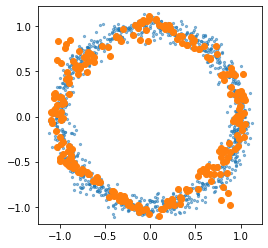

In [36]:
data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

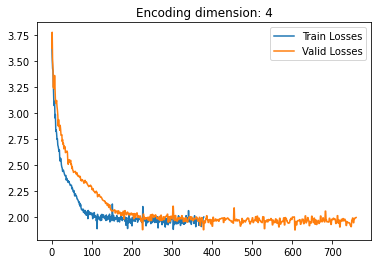

In [37]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title(f'Encoding dimension: {encoding_dim}')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

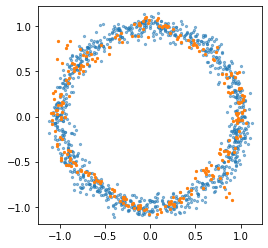

In [38]:
d = PointDataset('/content/DatasetA_test.npy')
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), s=5)
plt.axis('equal');

## Encoding Dimension: 16

In [39]:
# Prior
input_dim = 2
encoding_dim = 16
hidden_dim = 128
prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  23368


In [40]:
num_epoch = 10
train_losses = []
valid_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in train_data:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        with torch.no_grad():
          model.eval()
          for point_batch in valid_data:
            
            m, s, loss = model(points.float())
            valid_losses.append(loss)
          
          model.train()


        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

[2/10] 2.0661678314208984
--------------------
[5/10] 1.9837791919708252
--------------------
[7/10] 1.9566962718963623
--------------------


torch.Size([256, 2])


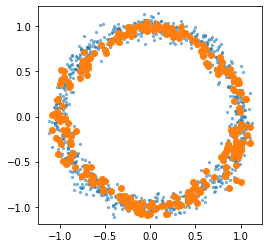

In [41]:
data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

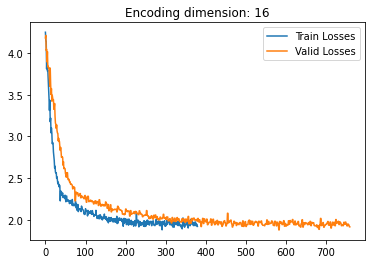

In [42]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title(f'Encoding dimension: {encoding_dim}')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

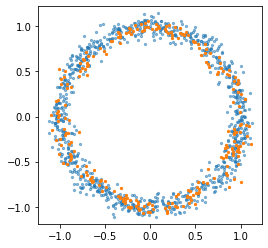

In [43]:
d = PointDataset('/content/DatasetA_test.npy')
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), s=5)
plt.axis('equal');

## Encoding Dimension: 64

In [44]:
# Prior
input_dim = 2
encoding_dim = 64
hidden_dim = 128
prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  29656


In [45]:
num_epoch = 10
train_losses = []
valid_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in train_data:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        with torch.no_grad():
          model.eval()
          for point_batch in valid_data:
            
            m, s, loss = model(points.float())
            valid_losses.append(loss)
          
          model.train()


        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

[2/10] 1.977051019668579
--------------------
[5/10] 1.9694148302078247
--------------------
[7/10] 1.9543036222457886
--------------------


torch.Size([256, 2])


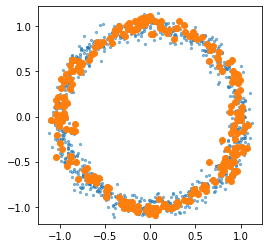

In [46]:
data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

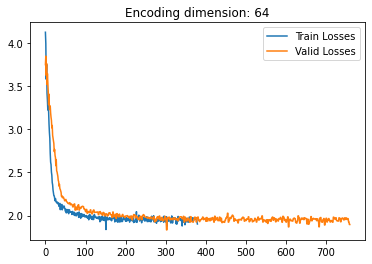

In [47]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title(f'Encoding dimension: {encoding_dim}')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

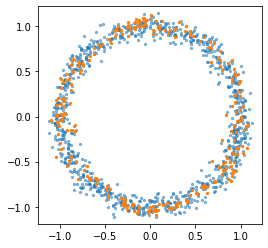

In [48]:
d = PointDataset('/content/DatasetA_test.npy')
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), s=5)
plt.axis('equal');

## Heatmap

## Different Hidden Dimensions
Similar to the encoding dimension, try different hidden dimensions. Train your model with 3 different sizes for **h**.

### Results
Plot the training and validation losses. Again, show the heatmap of best model.

## Hidden Dimension: 10

In [49]:
# Prior
input_dim = 2
encoding_dim = 16
hidden_dim = 10
prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  4488


In [50]:
num_epoch = 10
train_losses = []
valid_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in train_data:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        with torch.no_grad():
          model.eval()
          for point_batch in valid_data:
            
            m, s, loss = model(points.float())
            valid_losses.append(loss)
          
          model.train()


        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

[2/10] 2.694999933242798
--------------------
[5/10] 2.029360055923462
--------------------
[7/10] 1.9513134956359863
--------------------


torch.Size([256, 2])


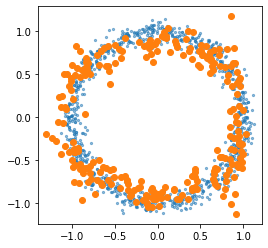

In [51]:
data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

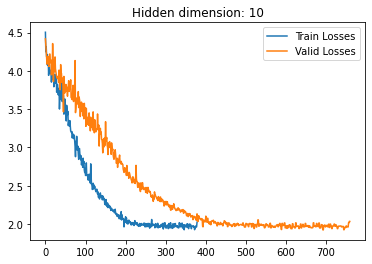

In [52]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title(f'Hidden dimension: {hidden_dim}')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

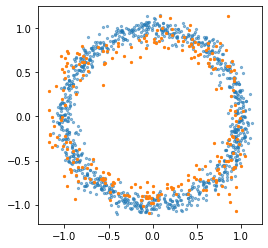

In [53]:
d = PointDataset('/content/DatasetA_test.npy')
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), s=5)
plt.axis('equal');

## Hidden Dimension: 64

In [54]:
# Prior
input_dim = 2
encoding_dim = 16
hidden_dim = 64
prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  9672


In [55]:
num_epoch = 10
train_losses = []
valid_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in train_data:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        with torch.no_grad():
          model.eval()
          for point_batch in valid_data:
            
            m, s, loss = model(points.float())
            valid_losses.append(loss)
          
          model.train()


        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

[2/10] 2.0314581394195557
--------------------
[5/10] 1.9591131210327148
--------------------
[7/10] 2.0141754150390625
--------------------


torch.Size([256, 2])


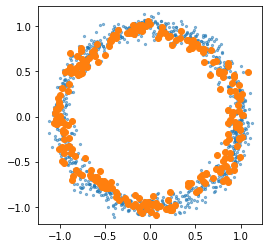

In [56]:
data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

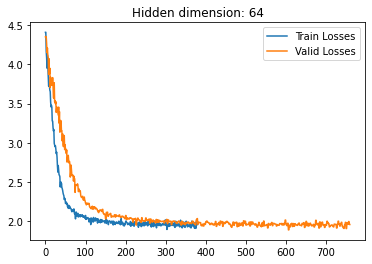

In [57]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title(f'Hidden dimension: {hidden_dim}')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

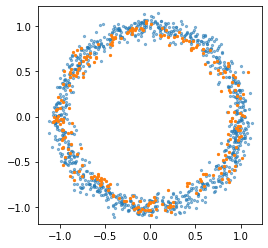

In [58]:
d = PointDataset('/content/DatasetA_test.npy')
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), s=5)
plt.axis('equal');

## Hidden Dimension 128

In [59]:
# Prior
input_dim = 2
encoding_dim = 16
hidden_dim = 128
prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  23368


In [60]:
num_epoch = 10
train_losses = []
valid_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in train_data:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        with torch.no_grad():
          model.eval()
          for point_batch in valid_data:
            
            m, s, loss = model(points.float())
            valid_losses.append(loss)
          
          model.train()


        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

[2/10] 2.013948440551758
--------------------
[5/10] 1.9914703369140625
--------------------
[7/10] 1.9711511135101318
--------------------


torch.Size([256, 2])


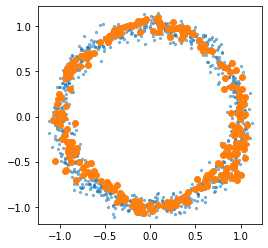

In [61]:
data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

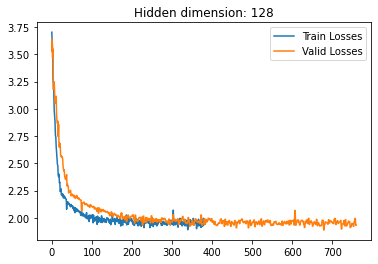

In [62]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title(f'Hidden dimension: {hidden_dim}')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

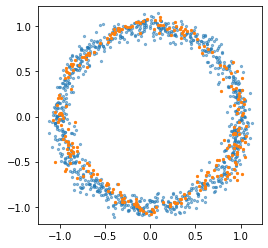

In [63]:
d = PointDataset('/content/DatasetA_test.npy')
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), s=5)
plt.axis('equal');

## Heatmap

# Dataset B

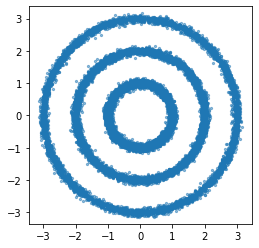

In [64]:
d = PointDataset('/content/DatasetB_train.npy')
x = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.axis('equal');

## Different Encoding Sizes
For this dataset, we will just use the learning rate we chose for Dataset A. This time, test 3 different encoding sizes on Dataset B.

### Results
Plot the training and validation losses. Plot the probabilities calculated by the best model.

## Encoding Dimension: 2

In [65]:
# Prior
input_dim = 2
encoding_dim = 2
hidden_dim = 128
prior = MultivariateNormal(torch.zeros(encoding_dim), torch.eye(encoding_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  21534


In [66]:
num_epoch = 10
train_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in x:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

[1/10] 3.9066414833068848
--------------------
[3/10] 3.6637494564056396
--------------------
[5/10] 3.7150425910949707
--------------------
[6/10] 3.6007556915283203
--------------------
[8/10] 3.718470335006714
--------------------


torch.Size([256, 2])


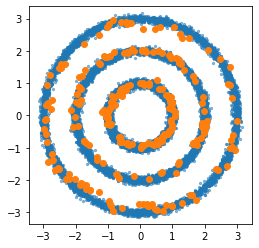

In [67]:
data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


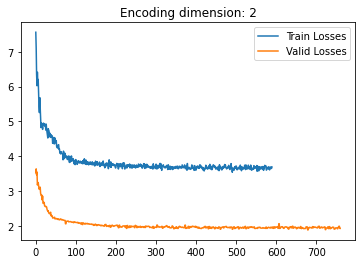

In [68]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title(f'Encoding dimension: {encoding_dim}')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

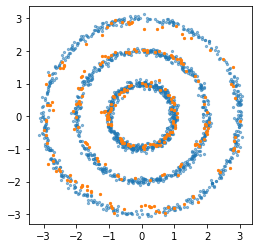

In [69]:
d = PointDataset('/content/DatasetB_test.npy')
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), s=5)
plt.axis('equal');

## Encoding Dimension: 16

In [70]:
# Prior
input_dim = 2
encoding_dim = 16
hidden_dim = 128
prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  23368


In [71]:
num_epoch = 10
train_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in x:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

[1/10] 3.7067039012908936
--------------------
[3/10] 3.652484178543091
--------------------
[5/10] 3.713923931121826
--------------------
[6/10] 3.6707913875579834
--------------------
[8/10] 3.598612070083618
--------------------


torch.Size([256, 2])


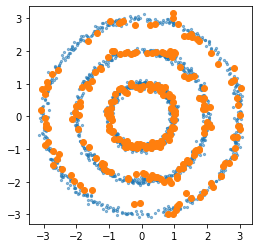

In [72]:
data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


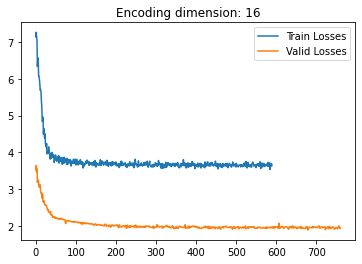

In [73]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title(f'Encoding dimension: {encoding_dim}')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

## Encoding Dimension: 64

In [74]:
# Prior
input_dim = 2
encoding_dim = 16
hidden_dim = 128
prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  23368


In [75]:
num_epoch = 10
train_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in x:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

[1/10] 3.6472959518432617
--------------------
[3/10] 3.592259168624878
--------------------
[5/10] 3.704416275024414
--------------------
[6/10] 3.7346725463867188
--------------------
[8/10] 3.6278791427612305
--------------------


torch.Size([256, 2])


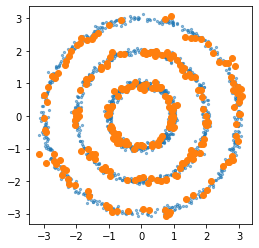

In [76]:
data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


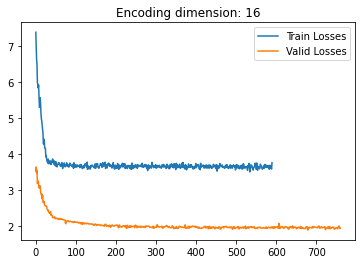

In [77]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title(f'Encoding dimension: {encoding_dim}')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

## Heatmap

## Different Hidden Dimensions

In your final experiment, optimize the size of **h** on Dataset B by comparing 3 different hidden dimensions.

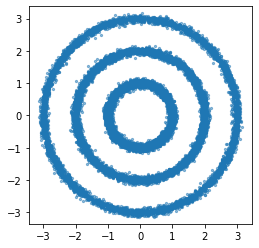

In [78]:
d = PointDataset('/content/DatasetB_train.npy')
x = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.axis('equal');

## Hidden Dimension: 10

In [79]:
# Prior
input_dim = 2
encoding_dim = 16
hidden_dim = 10
prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  4488


In [80]:
num_epoch = 10
train_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in x:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

[1/10] 5.678364276885986
--------------------
[3/10] 3.8271777629852295
--------------------
[5/10] 3.7105889320373535
--------------------
[6/10] 3.6995739936828613
--------------------
[8/10] 3.6785497665405273
--------------------


torch.Size([256, 2])


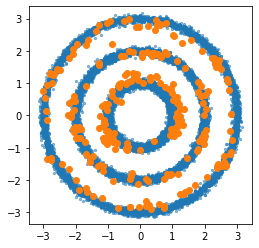

In [81]:
data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

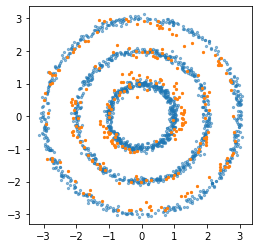

In [82]:
d = PointDataset('/content/DatasetB_test.npy')
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), s=5)
plt.axis('equal');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


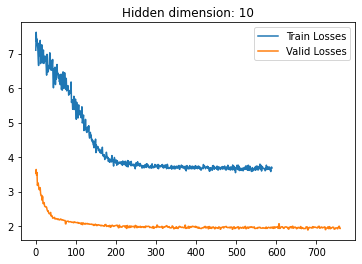

In [83]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title(f'Hidden dimension: {hidden_dim}')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

## Hidden Dimension: 32

number of params:  5896
[1/10] 3.7703282833099365
--------------------
[3/10] 3.624925374984741
--------------------
[5/10] 3.638385534286499
--------------------
[6/10] 3.6174778938293457
--------------------
[8/10] 3.644655466079712
--------------------
torch.Size([256, 2])


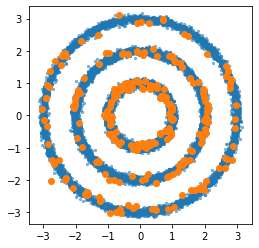

In [84]:
d = PointDataset('/content/DatasetB_train.npy')
# Prior
input_dim = 2
encoding_dim = 16
hidden_dim = 32
prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

num_epoch = 10
train_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in x:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

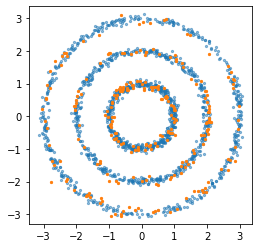

In [85]:
d = PointDataset('/content/DatasetB_test.npy')
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), s=5)
plt.axis('equal');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


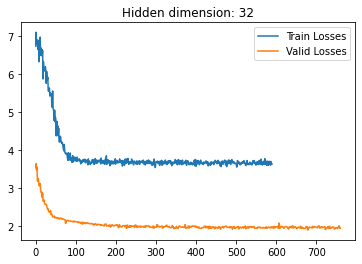

In [86]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title(f'Hidden dimension: {hidden_dim}')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

## Hidden Dimension: 500

number of params:  265168
[1/10] 3.78873610496521
--------------------
[3/10] 3.67893123626709
--------------------
[5/10] 3.660503387451172
--------------------
[6/10] 3.702826499938965
--------------------
[8/10] 3.7070770263671875
--------------------
torch.Size([256, 2])


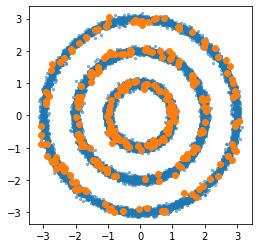

In [87]:
d = PointDataset('/content/DatasetB_train.npy')
# Prior
input_dim = 2
encoding_dim = 16
hidden_dim = 500
prior = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
flows = [IAF(dim=2, parity=0, nh=24) for i in range(3)]
# construct the model
model = VAE(input_dim, encoding_dim, hidden_dim, prior, flows)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

num_epoch = 10
train_losses = []
steps = 0
for epoch in range(num_epoch):
    for points in x:
        m, s, loss = model(points.float())
        
        train_losses.append(loss)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        steps += 1

        if steps % 100 == 0:
            print(f"[{epoch}/{num_epoch}] {loss.item()}")
            print('--------------------')

data_loader = torch.utils.data.DataLoader(d, batch_size=256, shuffle=True)
data = next(iter(data_loader))
print(data.size())
m, s, loss = model(data)
m.detach()
s.detach()
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
plt.axis('equal');

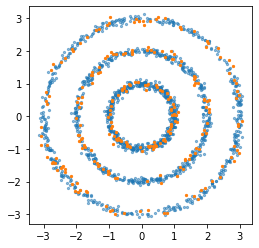

In [88]:
d = PointDataset('/content/DatasetB_test.npy')
samples = m + torch.exp(s)*torch.randn(s.size())
plt.figure(figsize=(4,4))
plt.scatter(d[:,0], d[:,1], s=5, alpha=0.5)
plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), s=5)
plt.axis('equal');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


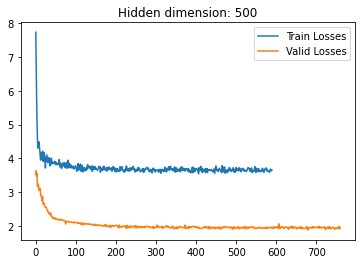

In [89]:
train_losses = torch.tensor(train_losses)
valid_losses = torch.tensor(valid_losses)
plt.title(f'Hidden dimension: {hidden_dim}')
plt.plot(train_losses.detach().numpy(), label='Train Losses')
plt.plot(valid_losses.detach().numpy(), label = 'Valid Losses')
plt.legend();

## Heatmap